In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob

import time

def filtering_func(freqs, ffts, phases, f1, f2):  #passing complex numbers
    avg_fft = np.mean(np.abs(ffts), axis = 0)
    n = max(avg_fft)

    noise_fft = ffts.copy()

    valid_indices = np.where((freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1))[0]

    fft_in_range = avg_fft[valid_indices]
    print(f'fft_in_range: {fft_in_range/n} ')

    peak = np.max(fft_in_range)

    local_peak_indices = np.where(fft_in_range == peak)[0]
    general_peak_indices = valid_indices[local_peak_indices]
    print(f"general_peak_indices: {general_peak_indices}")
    print(f"abs_fft[general_peak_indices]: {avg_fft[general_peak_indices]/n}")

    peak_f = freqs[general_peak_indices]
    print(f"peak_f: {peak_f}")

    peak_phase = phases[general_peak_indices]
    print(f"peak_phase: {peak_phase}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    mask = np.ones(noise_fft.shape, dtype=bool)
    mask[:, general_peak_indices] = False
    noise_fft[mask] = complex(0, 0)
    return noise_fft, peak_f, peak_phase

In [2]:
hour = '15.42'
day = '08082024'

In [3]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values #If ‘coerce’, then invalid parsing will be set as NaN.
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values #If ‘coerce’, then invalid parsing will be set as NaN.
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)       

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object


In [4]:
N = len(times)
print(f"len(times): {N}")

len(times): 62504


## FFT

In [5]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.fftfreq(len(times), 1/f_s) #window lenght, sample spacing
print(f'last freq: {freqs[-1]}') ##this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905822
last freq: -0.019999039778103515
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [6]:
all_magnitudes = fft.fft(all_amplitudes, axis = 1) #when i'm filtering, i'm filtering something complex
avg_fft = np.mean(np.abs(all_magnitudes), axis = 0)
n = np.max(avg_fft)

all_phases = np.angle(all_magnitudes)
avg_phases = np.mean(all_phases, axis = 0)

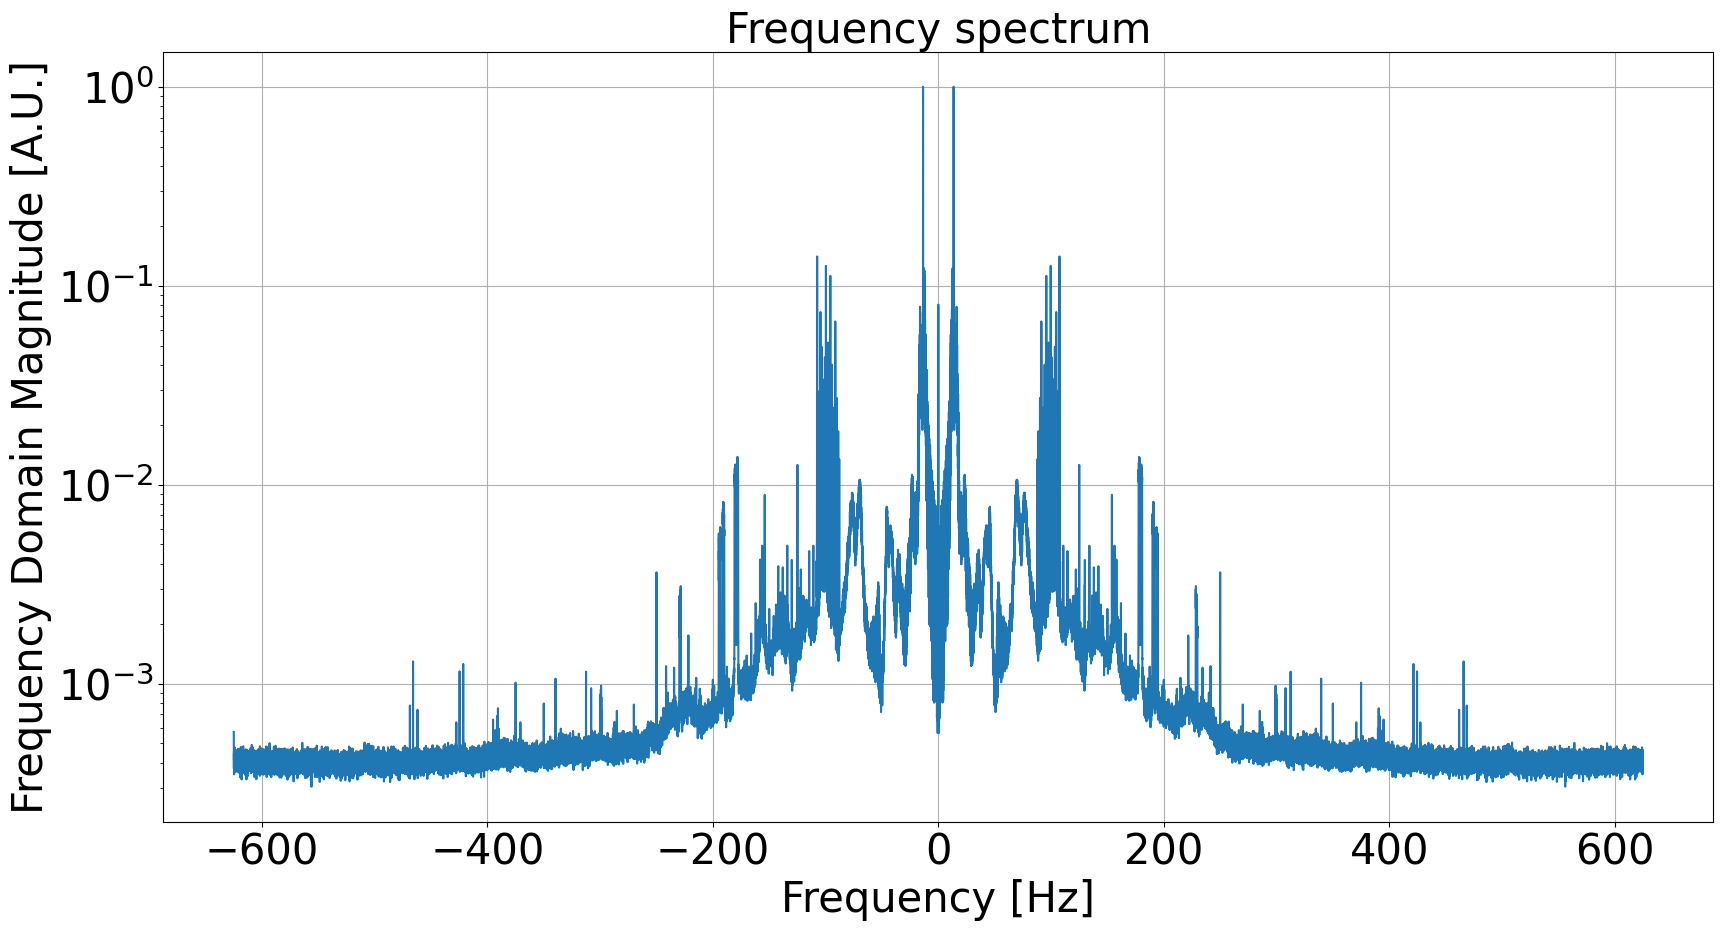

In [7]:
freqs_shifted = fft.fftshift(freqs)
avg_fft_shifted = fft.fftshift(avg_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(avg_fft_shifted)/n)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

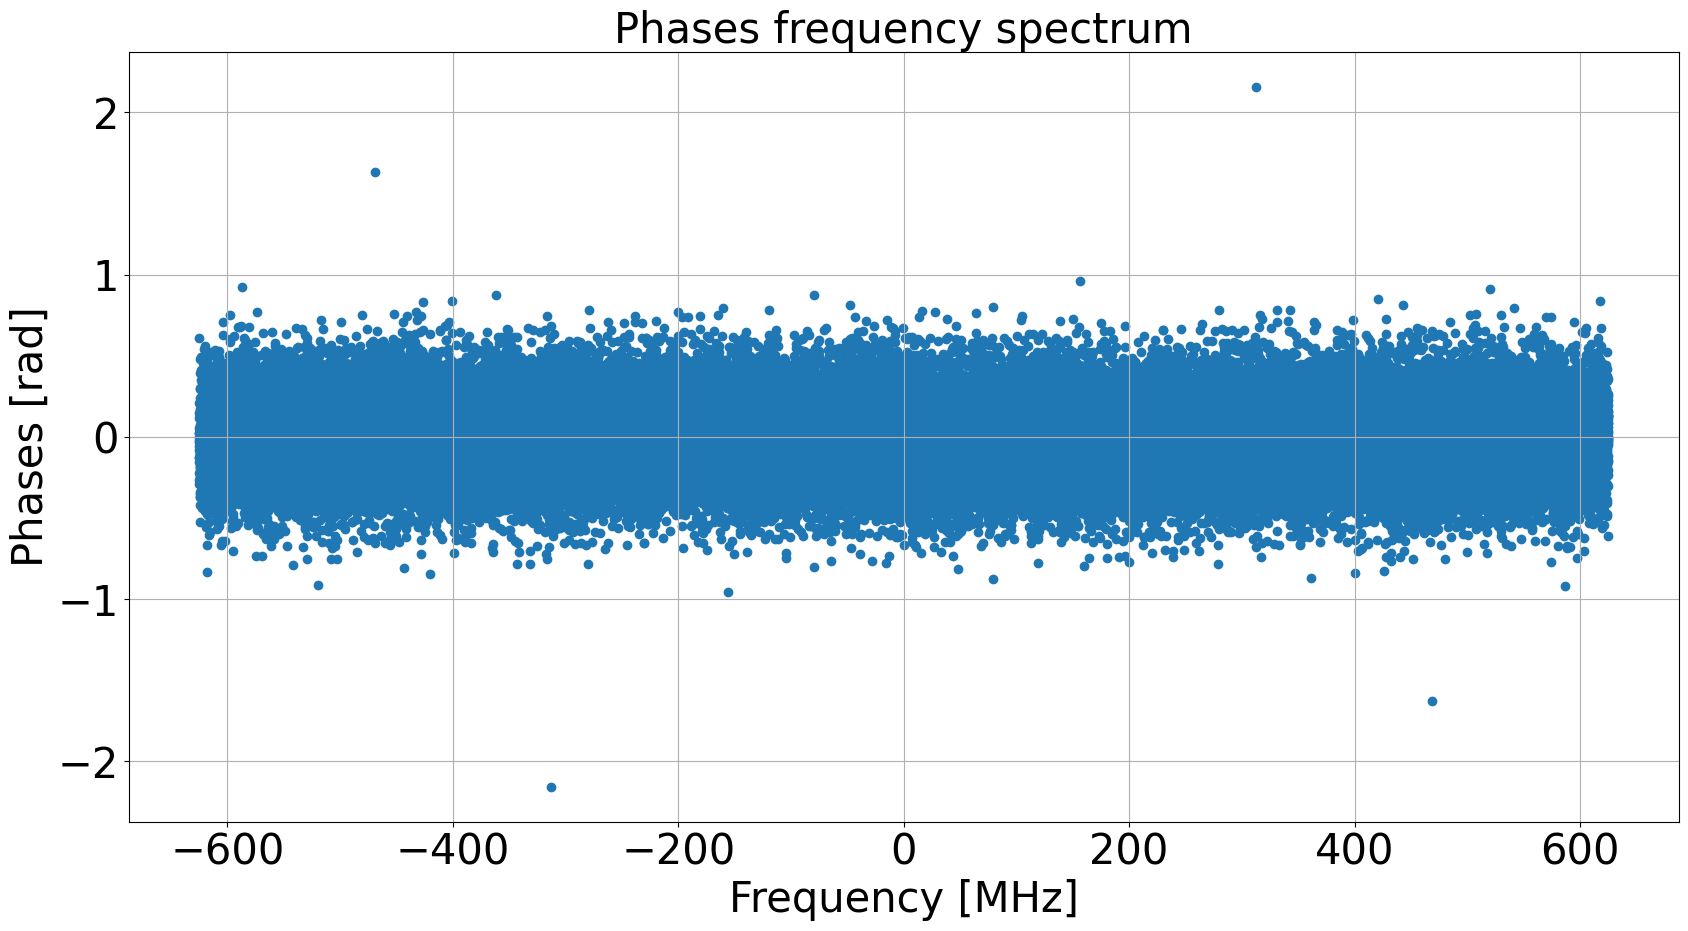

In [8]:
plt.figure(figsize=(20, 10))
plt.scatter(freqs, avg_phases)

plt.title('Phases frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phases [rad]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [9]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_avg_fft = avg_fft[:round((N/2))]
    pos_avg_phases = avg_phases[:round((N/2))]
    pos_amplitudes = amplitudes[:round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_avg_fft = avg_fft[:round((N-1)/2 + 1)]
    pos_avg_phases = avg_phases[:round((N-1)/2 + 1)]
    pos_amplitudes = amplitudes[:round((N-1)/2 + 1)]

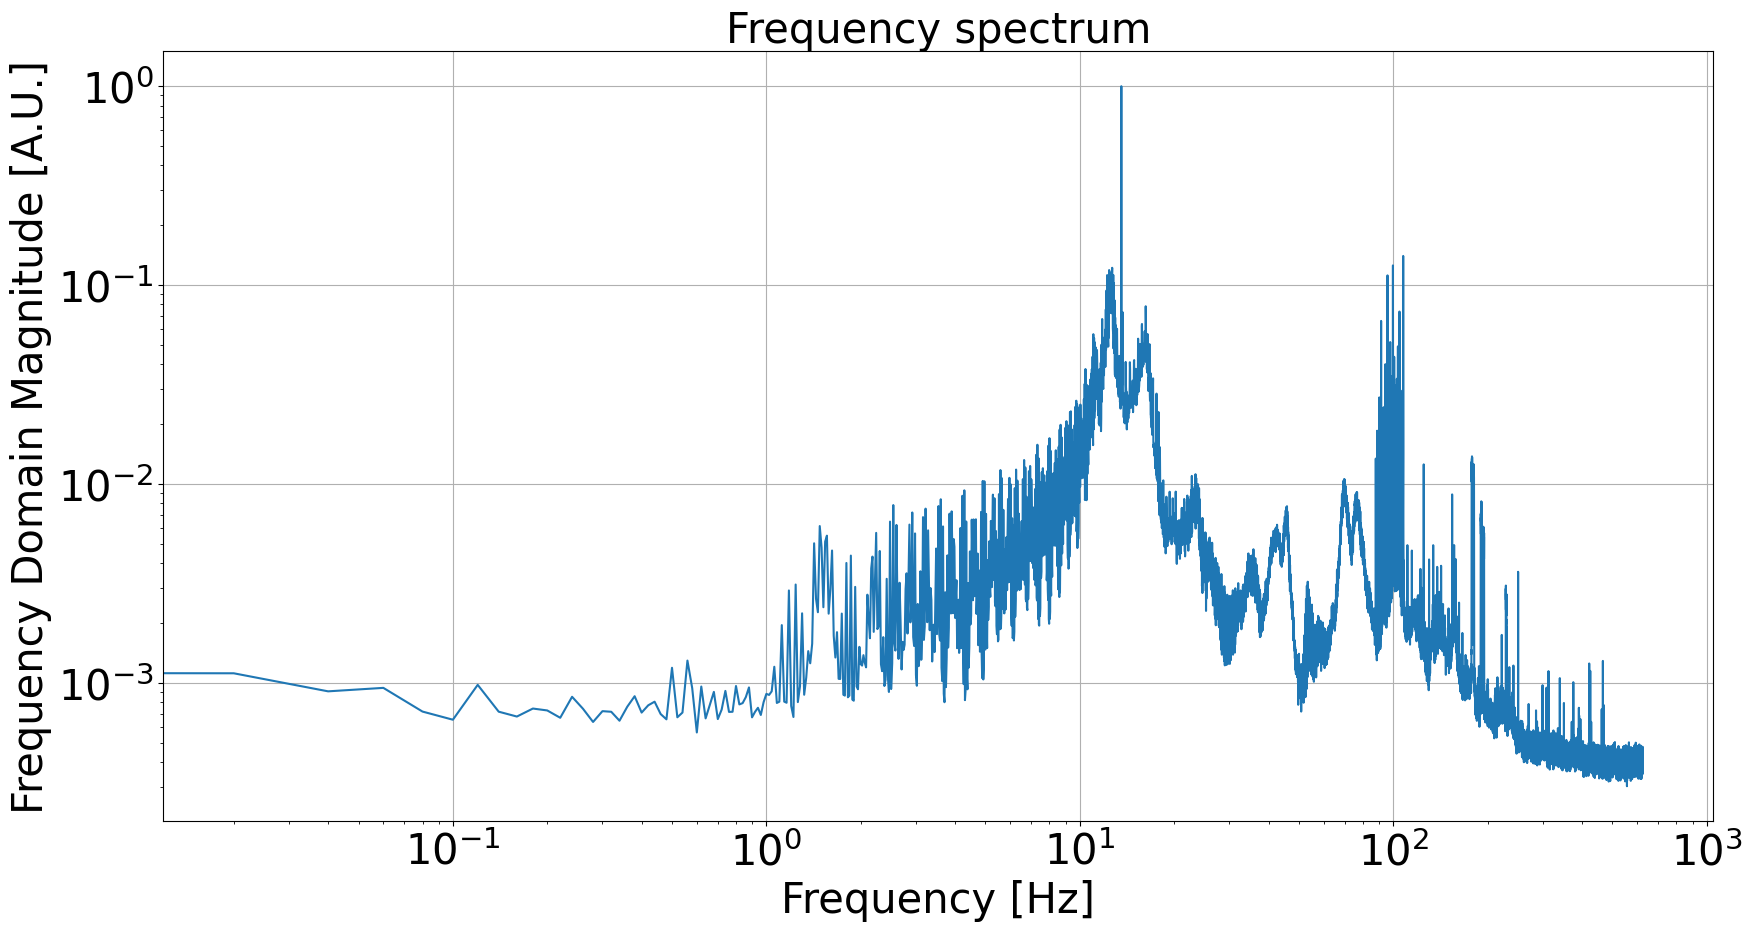

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(pos_freqs, np.abs(pos_avg_fft)/n)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.loglog()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

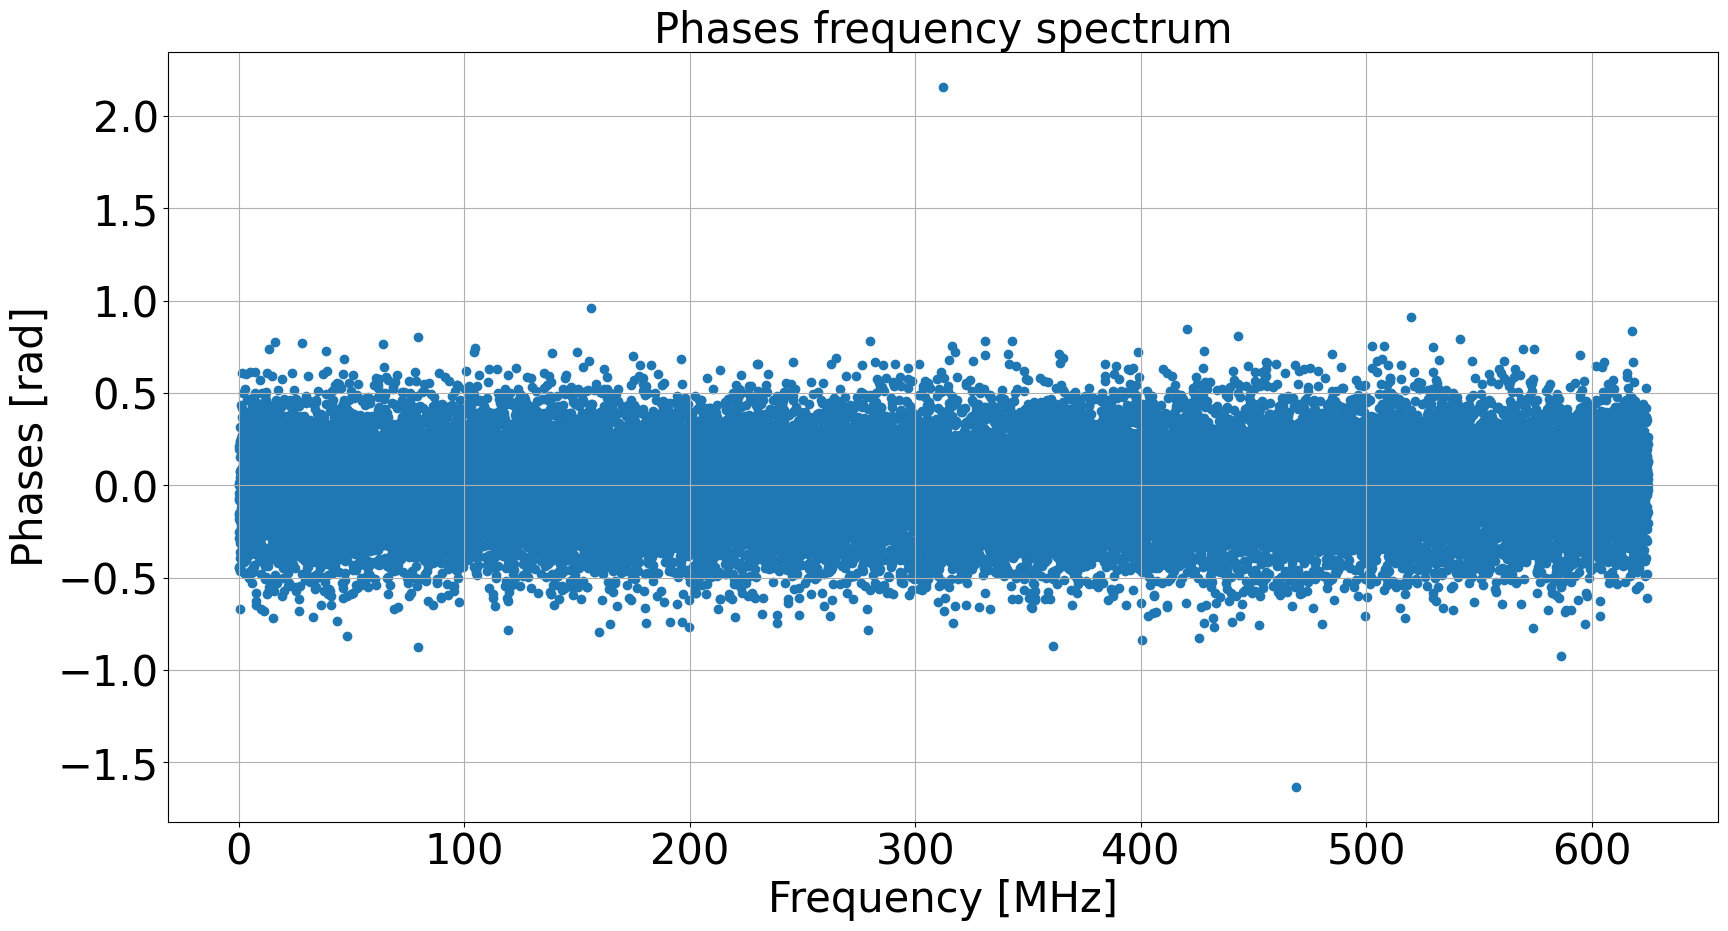

In [11]:
plt.figure(figsize=(20, 10))
plt.scatter(pos_freqs, pos_avg_phases)

plt.title('Phases frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phases [rad]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [12]:
f1 = 13
f2 = 14

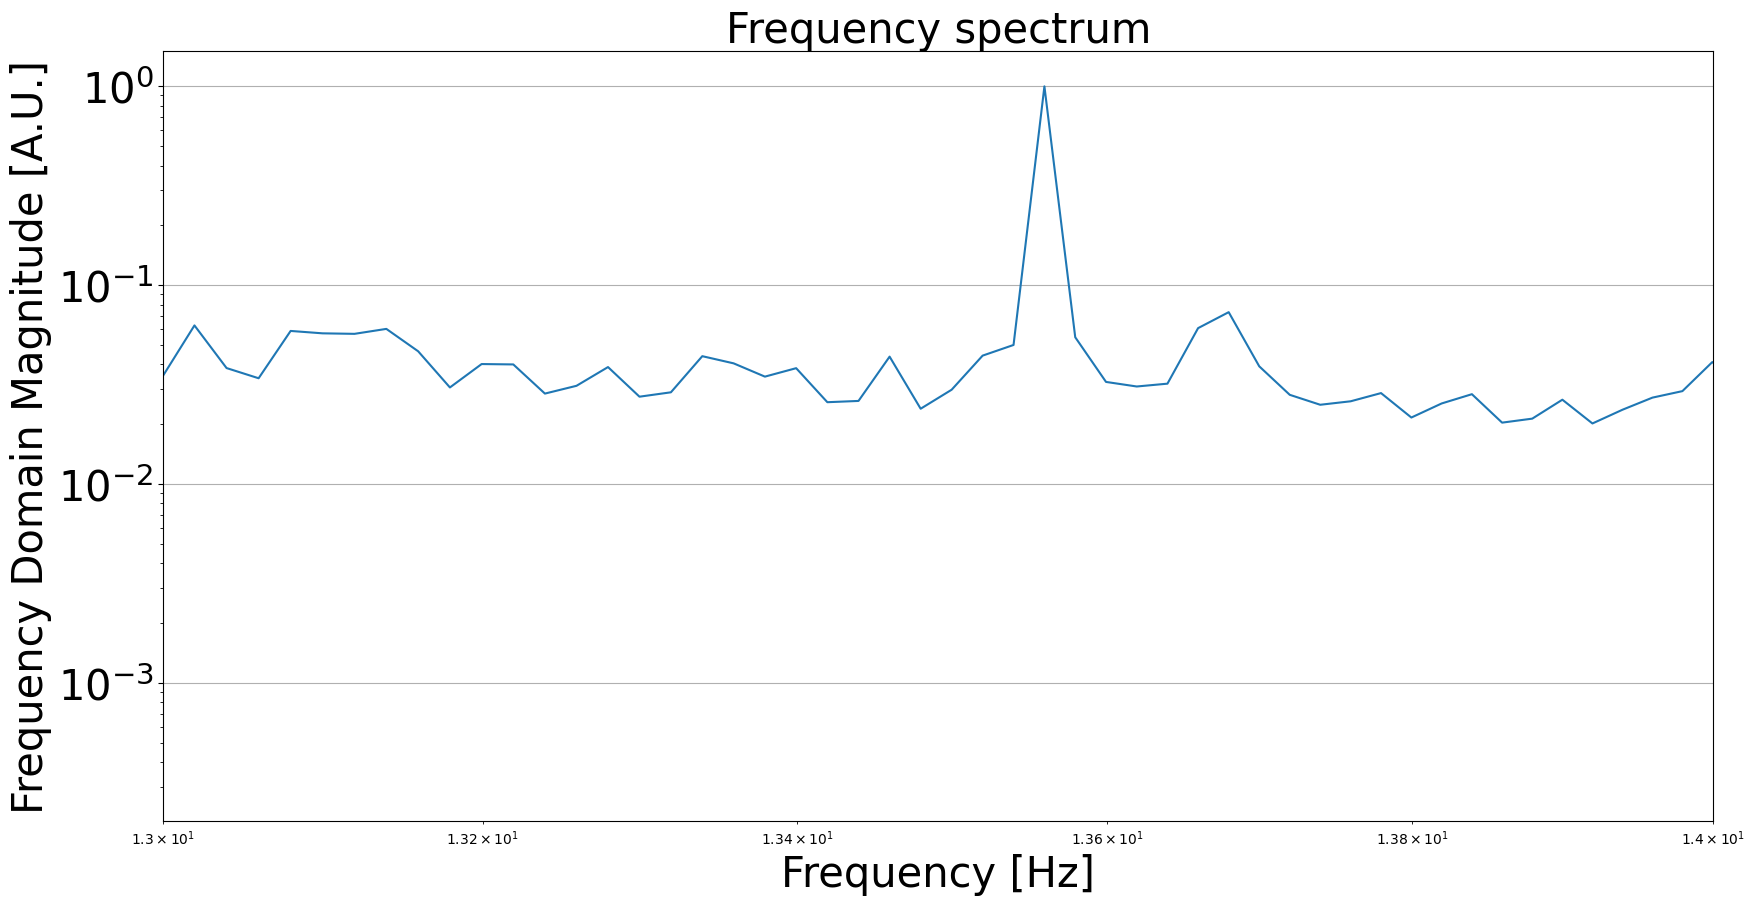

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(pos_freqs, np.abs(pos_avg_fft)/n)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.loglog()
plt.xlim(f1, f2)
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

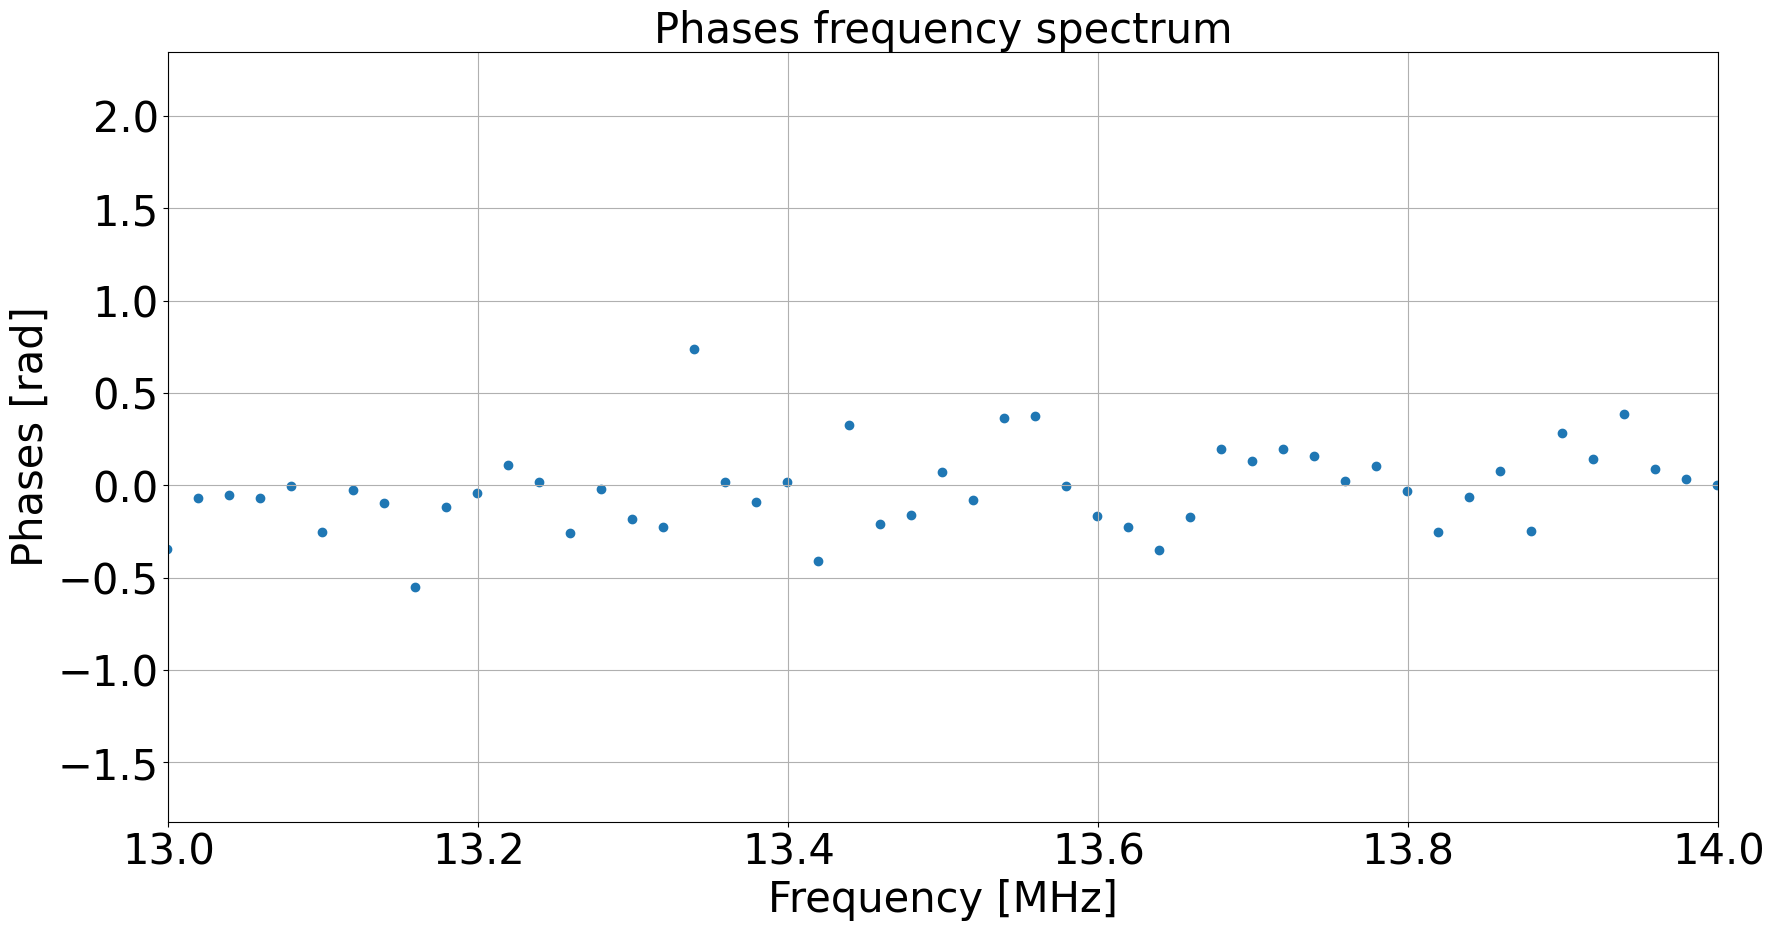

In [14]:
plt.figure(figsize=(20, 10))
plt.scatter(pos_freqs, pos_avg_phases)

plt.title('Phases frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phases [rad]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(f1, f2)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## Filtering

In [15]:
noise_ffts, peak_f, peak_phases = filtering_func(freqs, all_magnitudes, avg_phases, f1, f2)
avg_noise_fft = np.mean(np.abs(noise_ffts), axis = 0)

fft_in_range: [0.06283239 0.03836001 0.03408982 0.05894811 0.0573373  0.05700084
 0.06036589 0.04658497 0.03064742 0.04018227 0.04000562 0.02854666
 0.03123717 0.03880201 0.02754103 0.02897443 0.04401564 0.04050957
 0.03473978 0.03830908 0.02583741 0.02622025 0.04378405 0.02395749
 0.02985617 0.04429852 0.05011606 1.         0.05478877 0.03267317
 0.03099009 0.03202164 0.06089555 0.07325747 0.03913789 0.02814406
 0.02508365 0.02611231 0.02871157 0.02163785 0.02546372 0.0283484
 0.02039627 0.02136207 0.02659739 0.02020158 0.02367976 0.02724602
 0.02937242 0.04111193 0.04111193 0.02937242 0.02724602 0.02367976
 0.02020158 0.02659739 0.02136207 0.02039627 0.0283484  0.02546372
 0.02163785 0.02871157 0.02611231 0.02508365 0.02814406 0.03913789
 0.07325747 0.06089555 0.03202164 0.03099009 0.03267317 0.05478877
 1.         0.05011606 0.04429852 0.02985617 0.02395749 0.04378405
 0.02622025 0.02583741 0.03830908 0.03473978 0.04050957 0.04401564
 0.02897443 0.02754103 0.03880201 0.03123717 0.02

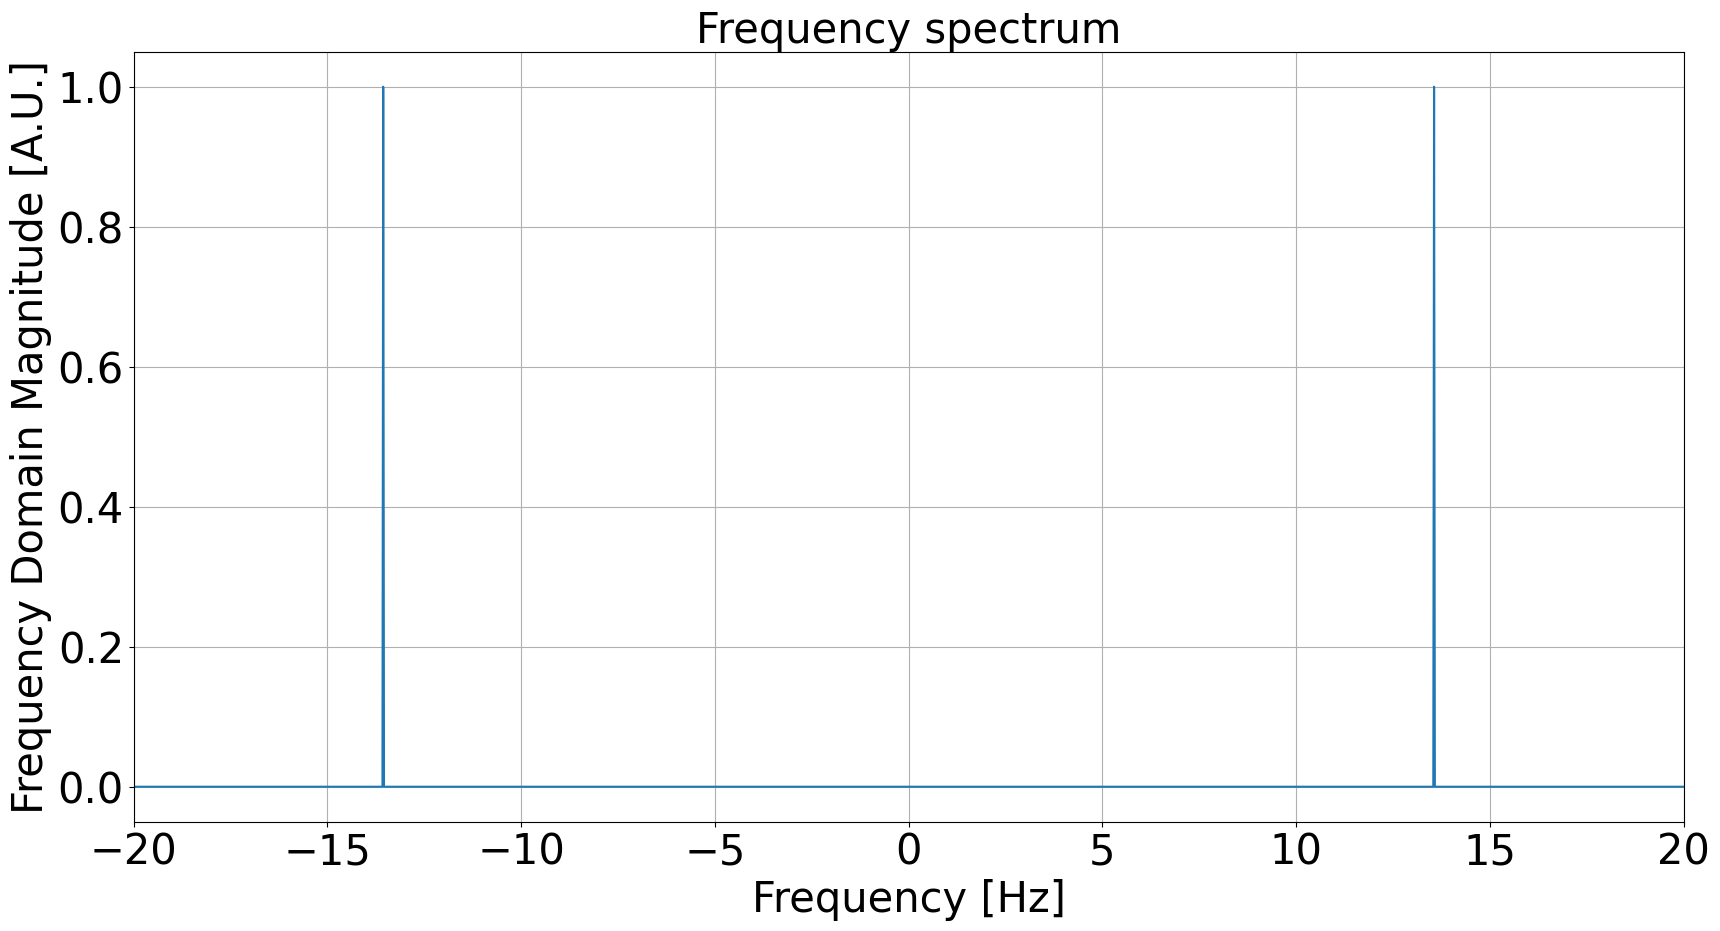

In [16]:
avg_noise_fft_shifted = fft.fftshift(avg_noise_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(avg_noise_fft_shifted)/n)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
#plt.xlim(- f_s / 2, f_s / 2) #freq of time sampling
plt.xlim(-20, 20)
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()


In [17]:
# times_new_2 = np.arange(N) / f_s_new

#noise_wf = np.sin(peak_f[0]* 2*np.pi * times + peak_phases[0])

noise_wfs = fft.ifft(noise_ffts, axis = 1)

## Compare to original waveform

In [18]:
all_reconstructed_amplitudes = fft.ifft(all_magnitudes)

filtered_amplitudes = all_reconstructed_amplitudes - noise_wfs

In [19]:
filtered_fft = fft.fft(filtered_amplitudes, axis = 1)
avg_filtered_fft = np.mean(np.abs(filtered_fft), axis = 0)

In [20]:
avg_reconstructed_filtered_wf = fft.ifft(avg_filtered_fft)

In [21]:
avg_reconstructed_wf = fft.ifft(avg_fft)

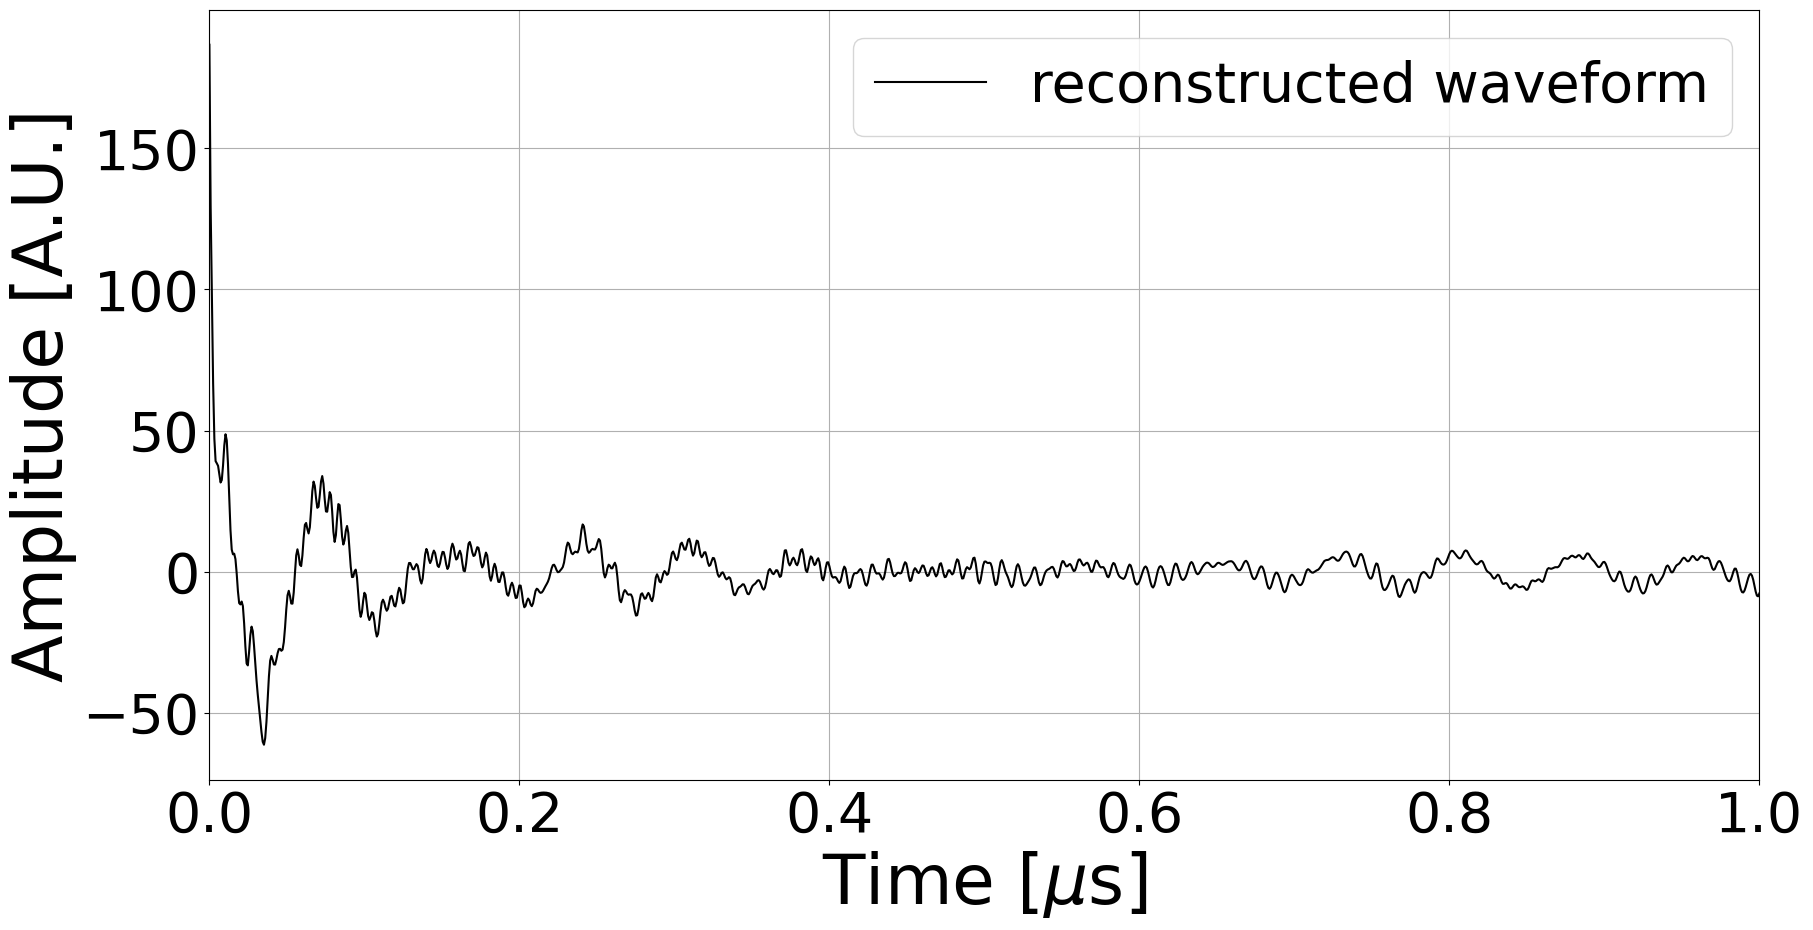

In [22]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_reconstructed_wf.real, label = 'reconstructed waveform', color = 'black')

plt.title('', fontsize = 50)
plt.xlabel(r'Time [$\mu$s]', fontsize = 50)
plt.xticks(fontsize = 40)
plt.ylabel('Amplitude [A.U.]', fontsize = 50)
plt.yticks(fontsize = 40)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 40)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method2_original_wf_test4.pdf", format = "pdf", bbox_inches="tight")
plt.show()

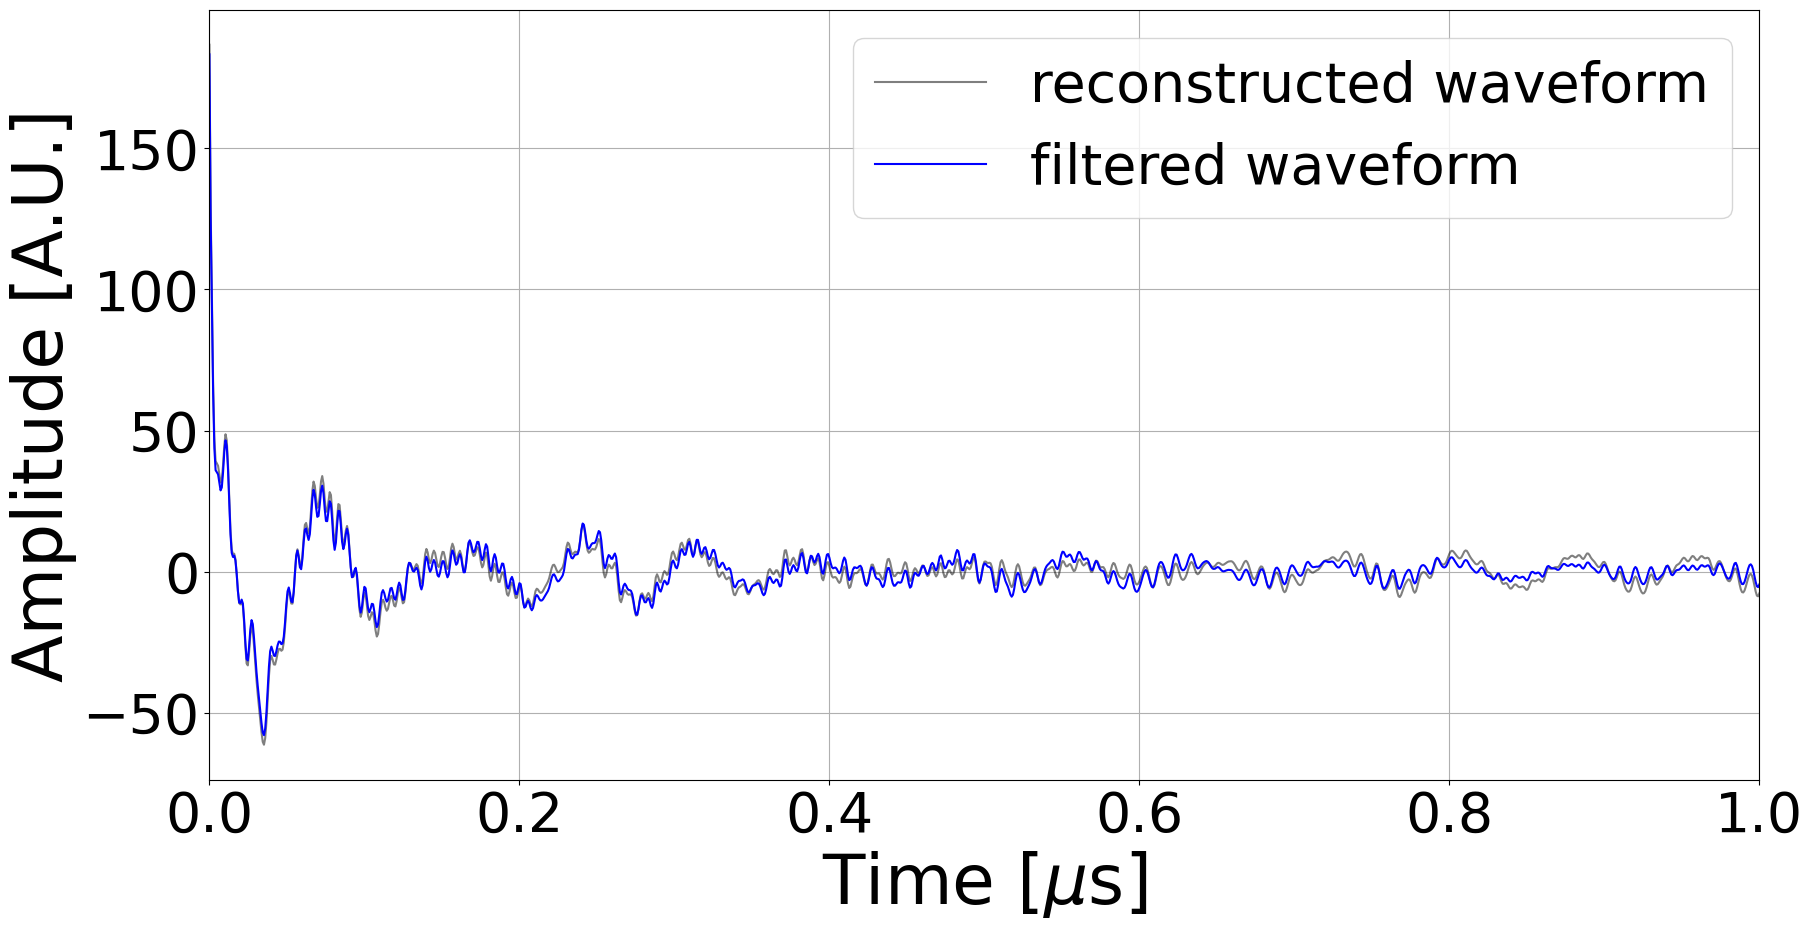

In [23]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_reconstructed_wf.real, label = 'reconstructed waveform', color = 'black', alpha = 0.5)
plt.plot(times, avg_reconstructed_filtered_wf.real, label = 'filtered waveform', color = 'blue')
plt.title('', fontsize = 50)
plt.xlabel(r'Time [$\mu$s]', fontsize = 50)
plt.xticks(fontsize = 40)
plt.ylabel('Amplitude [A.U.]', fontsize = 50)
plt.yticks(fontsize = 40)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 40)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method2_filtered_wf_test4.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [24]:
avg_noise_wf = avg_reconstructed_wf.real - avg_reconstructed_filtered_wf.real

In [25]:
A = max(avg_noise_wf.real)
f = peak_f[0]
phi = peak_phases[0]
coswave = A*np.cos(f*np.pi*2*times + phi)

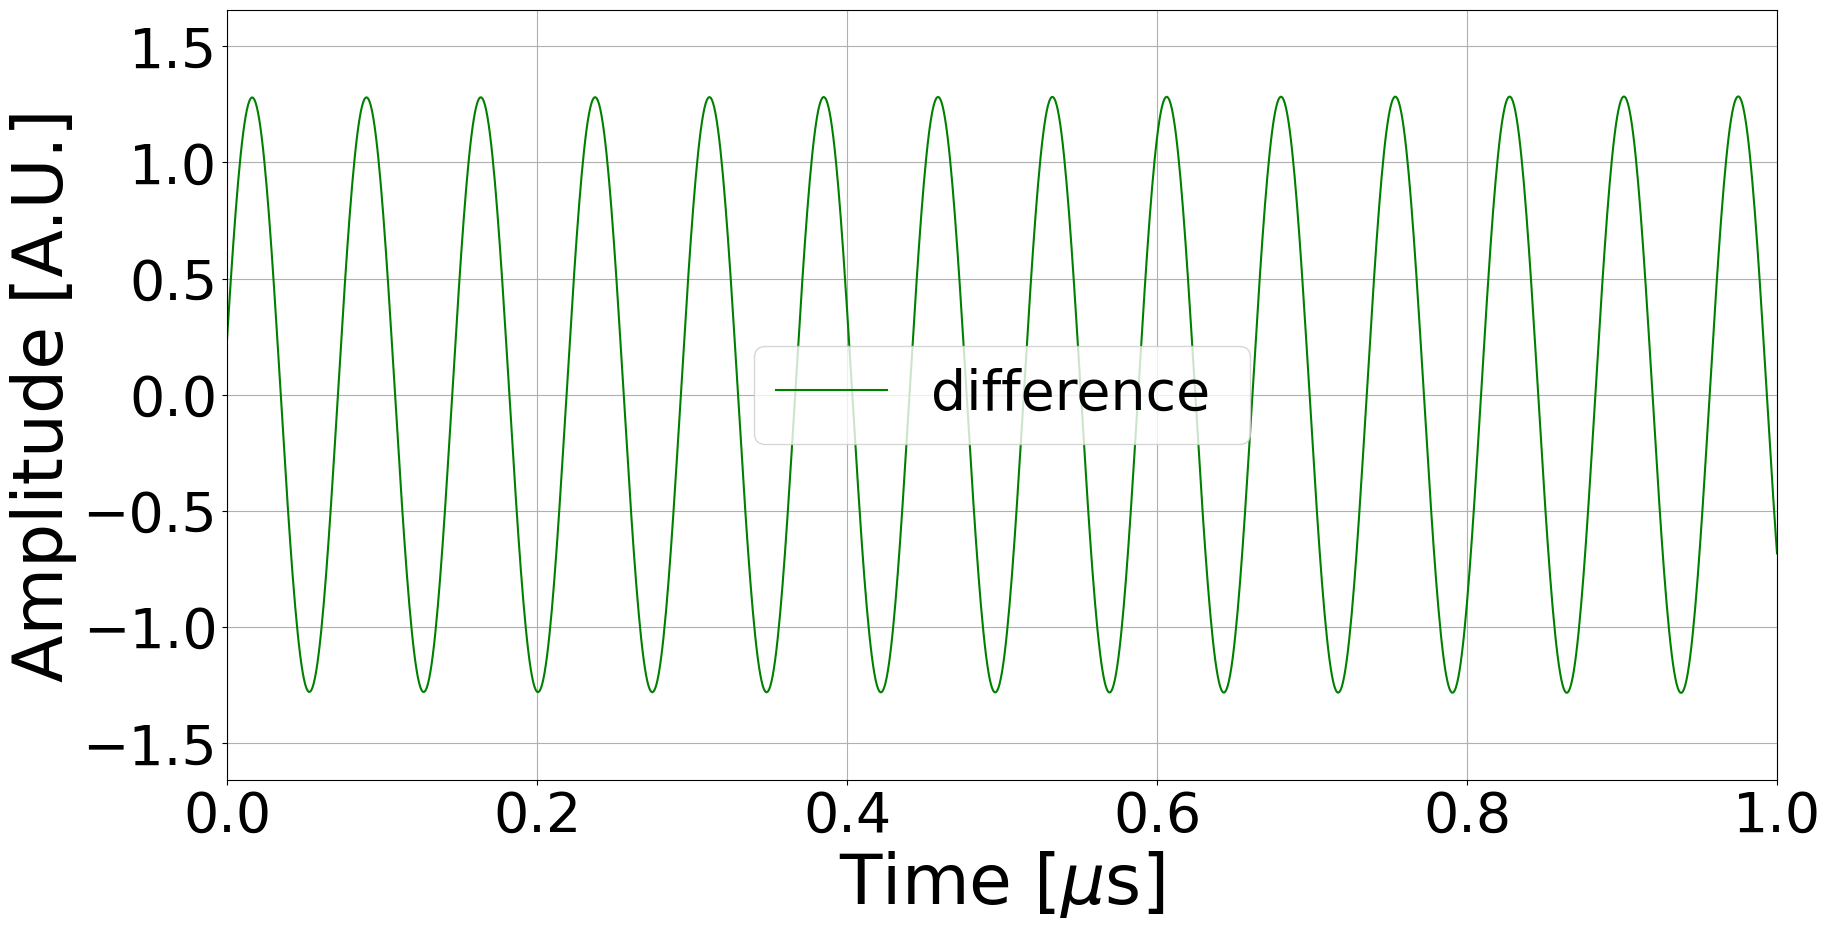

In [31]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_noise_wf - coswave, label = 'difference ', color = 'green')

plt.title('', fontsize = 50)
plt.xlabel(r'Time [$\mu$s]', fontsize = 50)
plt.xticks(fontsize = 40)
plt.ylabel('Amplitude [A.U.]', fontsize = 50)
plt.yticks(fontsize = 40)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 40)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
plt.savefig("../Results/080824_15.42/method2_noise_wf_test4.pdf", format = "pdf", bbox_inches="tight")
plt.show()

# Make sure reconstructed waveform and original waveform are not the same

In [27]:
avg_amplitudes = np.mean(all_amplitudes, axis = 0)

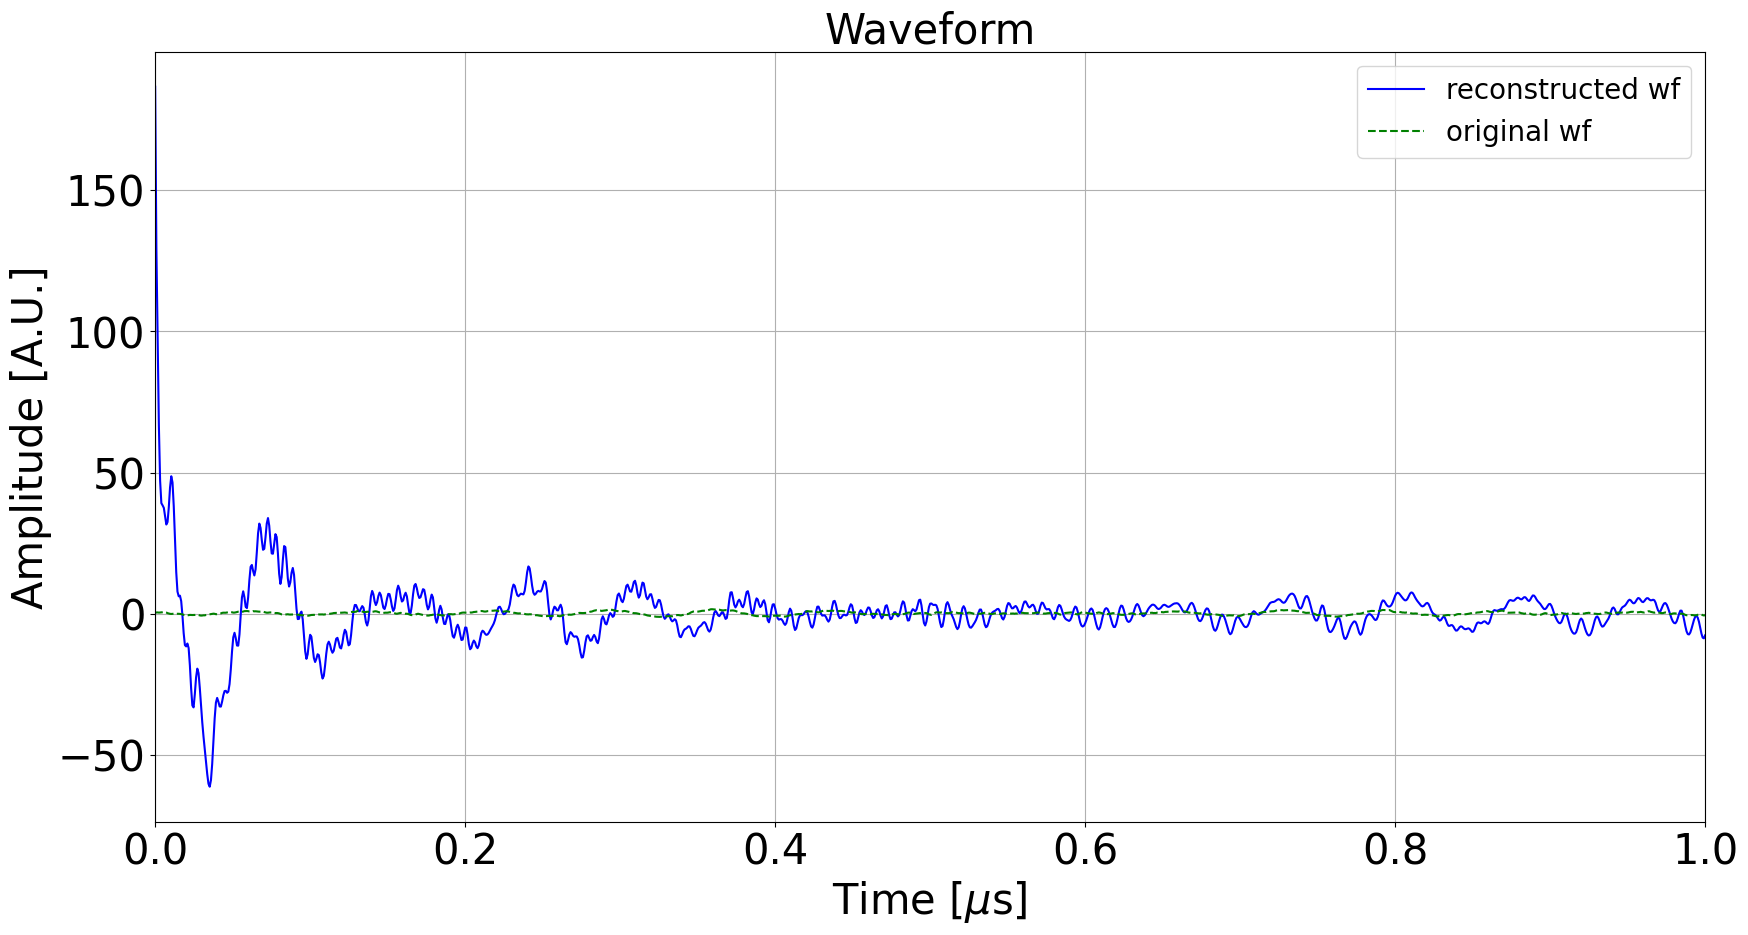

In [28]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_reconstructed_wf.real, label = 'reconstructed wf', color = 'blue') #why real?
plt.plot(times, avg_amplitudes, label = 'original wf', color = 'green', linestyle = '--')

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [29]:
avg_reconstructed_filtered_fft = fft.fft(avg_reconstructed_filtered_wf)

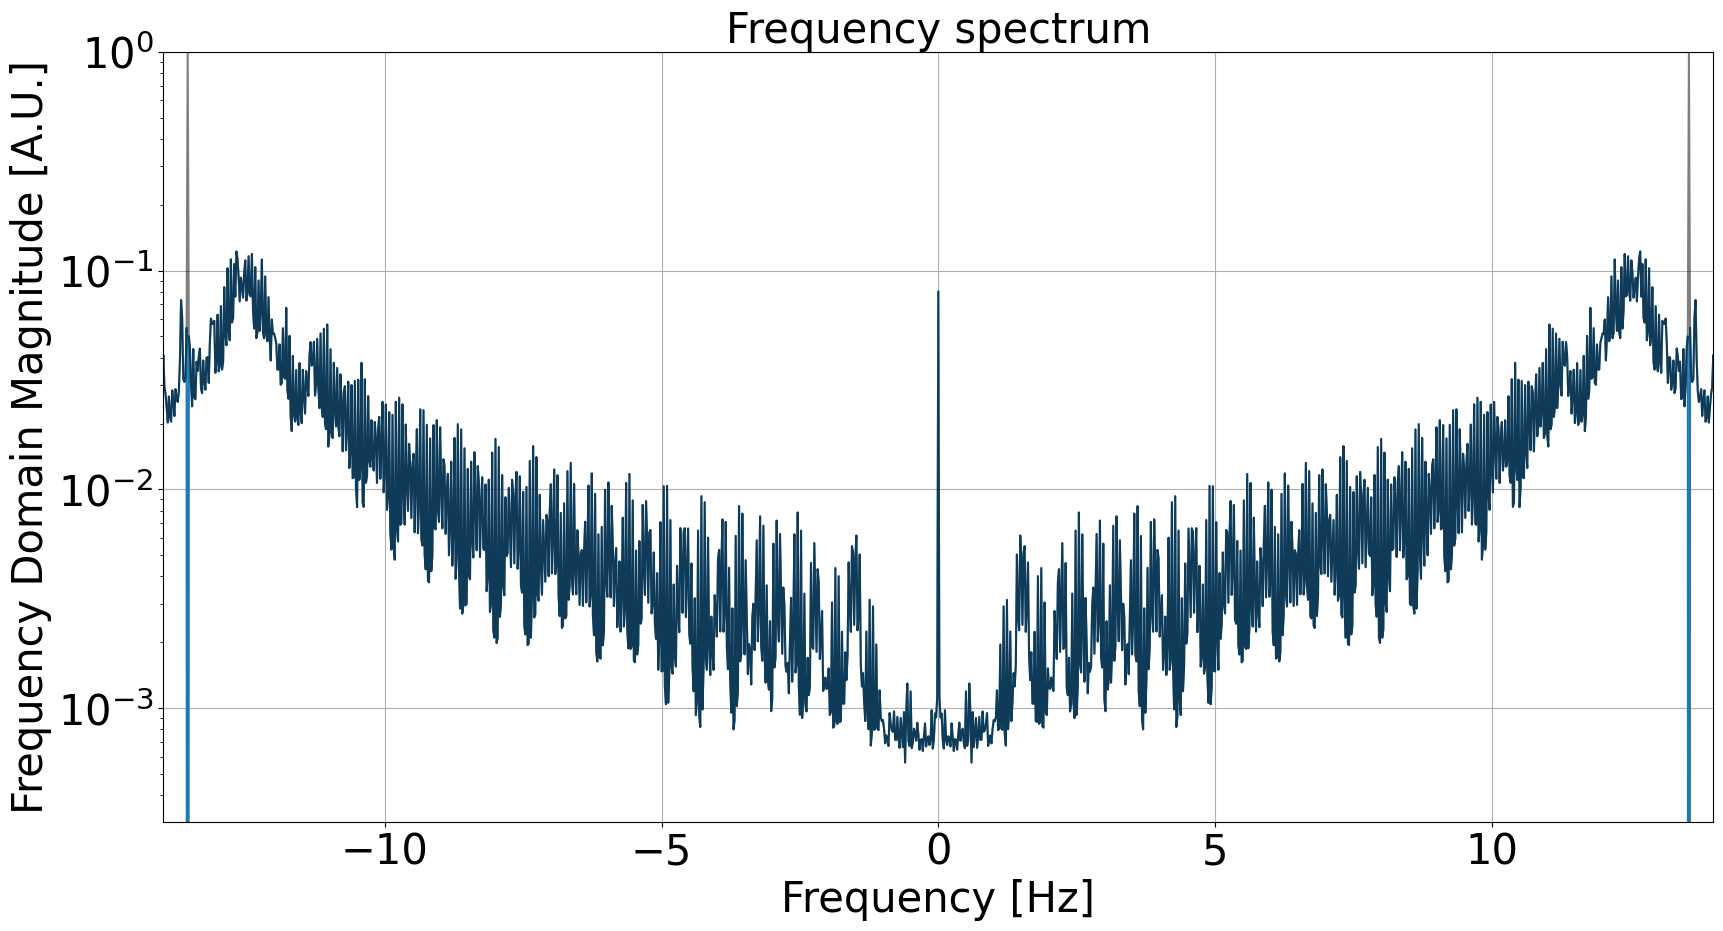

In [30]:
avg_reconstructed_filtered_fft_shifted = fft.fftshift(avg_reconstructed_filtered_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(avg_reconstructed_filtered_fft_shifted)/n)
plt.plot(freqs_shifted, np.abs(avg_fft_shifted)/n, color = 'k', alpha = 0.5)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
#plt.xlim(- f_s / 2, f_s / 2) #freq of time sampling
plt.semilogy()
plt.ylim([min(np.abs(avg_fft_shifted)/n), max(np.abs(avg_fft_shifted)/n)])  # Adjust the y-axis range
plt.xlim(-f2, f2)
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()